# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [0]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  1750k      0  0:00:04  0:00:04 --:--:-- 1981k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1009k      0  0:00:02  0:00:02 --:--:-- 1009k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  2651k      0  0:00:02  0:00:02 --:--:-- 2650k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0   812k      0  0:00:02  0:00:02 --:--:--  812k


In [0]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-13x52_6t/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-13x52_6t/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=34096 sha256=6010811bc8dc7103749d0c4297834effbff23f3e0b939c82e7cc77f150c77388
  Stored in directory: /tmp/pip-ephem-wheel-cache-bq2q8nw0/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")
# print(ratings_df)
# print(books_df)

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")



Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [0]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
rating_dataset_train, explict_validation = random_train_test_split(rating_dataset, random_state=np.random.RandomState(42))
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [0]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [0]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2945.03it/s]

0.0


#Q1



In [0]:
# baseline statistic data calculation
nonper_rec1 = ratings_df[["book_id", "rating"]].groupby(["book_id"]).mean().sort_values(by=['rating'], ascending=False)
nonper_rec2 = books_df[["book_id","ratings_count"]].groupby(["book_id"]).sum().sort_values(by=['ratings_count'], ascending=False)
nonper_rec3 = books_df[["book_id","ratings_5"]].groupby(["book_id"]).sum().sort_values(by=['ratings_5'], ascending=False)
nonper_rec4 = nonper_rec2.merge(nonper_rec3,how='left',on='book_id').reset_index()
nonper_rec4['fraction'] = nonper_rec4['ratings_5'] / nonper_rec4['ratings_count']
nonper_rec4 = nonper_rec4.drop(columns=['ratings_count','ratings_5']).groupby(["book_id"]).sum().sort_values(by=['fraction'], ascending=False)

class baselinemodel1:
  def __init__(self, numitems):
    self.predictions = nonper_rec1[0: numitems]
  def predict(self, uid):
    return( self.predictions )

class baselinemodel2:
  def __init__(self, numitems):
    self.predictions = nonper_rec2[0: numitems]
  def predict(self, uid):
    return( self.predictions )

class baselinemodel3:
  def __init__(self, numitems):
    self.predictions = nonper_rec3[0: numitems]
  def predict(self, uid):
    return( self.predictions )

class baselinemodel4:
  def __init__(self, numitems):
    self.predictions = nonper_rec4[0: numitems]
  def predict(self, uid):
    return( self.predictions )

In [147]:
print("MRR Score for this baseline model(Average rating):",mrr_score(baselinemodel1(num_items), test_dataset).mean())
print("MRR Score for this baseline model(Number of ratings):",mrr_score(baselinemodel2(num_items), test_dataset).mean())
print("MRR Score for this baseline model(Number of 5* ratings):",mrr_score(baselinemodel3(num_items), test_dataset).mean())
print("MRR Score for this baseline model(Fraction of 5* ratings):",mrr_score(baselinemodel4(num_items), test_dataset).mean())

MRR Score for this baseline model(Average rating): 0.058408405883614074
MRR Score for this baseline model(Number of ratings): 0.06928067208207278
MRR Score for this baseline model(Number of 5* ratings): 0.06928067208207278
MRR Score for this baseline model(Fraction of 5* ratings): 0.06928067208207278


#Q2

In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.evaluation import mrr_score

# Split explict data, done in cell above
rating_dataset_train, explict_validation = random_train_test_split(rating_dataset, random_state=np.random.RandomState(42))


emodel = ExplicitFactorizationModel(n_iter=5,
                                    embedding_dim=32, # after tuning this variable, best option is 32
                                    use_cuda=False)

print("Training Explicit Factorization Model...")
emodel.fit(rating_dataset_train, verbose=True)
print("MRR score tested on validation set:%.4f" % (mrr_score(emodel, explict_validation).mean()))
print("MRR score tested on test set:%.4f" % (mrr_score(emodel, test_dataset, train=rating_dataset).mean()))


imodel_0 = ImplicitFactorizationModel(loss = 'bpr',
                                    n_iter=5, 
                                    embedding_dim=16, # after tuning this variable, best option is 16
                                    use_cuda=False)

print("\nTraining Implicit Factorization Model...")
imodel_0.fit(rating_dataset_train, verbose=True)
print("MRR score tested on validation set:%.4f" % (mrr_score(imodel_0, explict_validation).mean()))
print("MRR score tested on test set:%.4f" % (mrr_score(imodel_0, test_dataset, train=rating_dataset).mean()))

Training Explicit Factorization Model...
Epoch 0: loss 4.5438603864266325
Epoch 1: loss 0.8014215594682939
Epoch 2: loss 0.6319218722673563
Epoch 3: loss 0.4911799482810192
Epoch 4: loss 0.3952183448351346
MRR score tested on validation set:0.0332
MRR score tested on test set:0.0444

Training Implicit Factorization Model...
Epoch 0: loss 0.3653127737916433
Epoch 1: loss 0.21220756012659805
Epoch 2: loss 0.17150749447636116
Epoch 3: loss 0.15507851667129077
Epoch 4: loss 0.14262114188227898
MRR score tested on validation set:0.1903
MRR score tested on test set:0.3652


#Q3

In [0]:
imodel_3 = ImplicitFactorizationModel(loss = 'bpr',
                                    n_iter=5, 
                                    embedding_dim=16, # after tuning this variable, best option is 16
                                    use_cuda=False)

print("Training Implicit Factorization Model...")
imodel_3.fit(toread_dataset_train, verbose=True)
print("MRR score tested on validation set:%.4f" % (mrr_score(imodel_3, validation).mean()))
RRs = mrr_score(imodel_3, test_dataset)
print("MRR score tested on test set:%.4f" % (RRs.mean()))


Training Implicit Factorization Model...
Epoch 0: loss 0.36429820079707875
Epoch 1: loss 0.21117266390542938
Epoch 2: loss 0.1751345376888255
Epoch 3: loss 0.15821403482893728
Epoch 4: loss 0.14760528981053042
MRR score tested on validation set:0.1850
MRR score tested on test set:0.2206


In [152]:
import scipy.stats as st
pd.options.display.max_rows = 50
RR_ranks = st.rankdata(-RRs, method="min") # "-" means the bigger the rank number will be smaller

print("User with id %d with RR %f" %( np.argwhere(RR_ranks==1).item(0), RRs[RR_ranks==1].item(0)))
print("User with id %d with RR %f" %( np.argwhere(RR_ranks==1).item(1), RRs[RR_ranks==1].item(1)))
print("User with id %d with RR %f" %( np.argwhere(RR_ranks==1).item(2), RRs[RR_ranks==1].item(2)))

print("For user",np.argwhere(RR_ranks==1).item(0),",His shelf got books shown below:")
print(to_read_df[to_read_df["user_id"] == np.argwhere(RR_ranks==1).item(0)].reset_index(drop = True))
print("For user",np.argwhere(RR_ranks==1).item(1),",His shelf got books shown below:")
print(to_read_df[to_read_df["user_id"] == np.argwhere(RR_ranks==1).item(1)].reset_index(drop = True))
print("For user",np.argwhere(RR_ranks==1).item(2),",His shelf got books shown below:")
print(to_read_df[to_read_df["user_id"] == np.argwhere(RR_ranks==1).item(2)].reset_index(drop = True))

User with id 8 with RR 1.000000
User with id 28 with RR 1.000000
User with id 31 with RR 1.000000
For user 8 ,His shelf got books shown below:
    Unnamed: 0  user_id  book_id
0          180        8      177
1        39177        8       80
2       230089        8       28
3       144862        8      560
4       230088        8      592
..         ...      ...      ...
58      144978        8      788
59          57        8     1937
60      230084        8      390
61      144963        8      769
62          60        8     1967

[63 rows x 3 columns]
For user 28 ,His shelf got books shown below:
    Unnamed: 0  user_id  book_id
0       131902       28        9
1       369157       28        1
2       297149       28      256
3       134622       28       28
4        46128       28      662
..         ...      ...      ...
77      131894       28      674
78      334037       28     1344
79      325984       28     1858
80        6032       28     1380
81      325967       28     1

In [0]:
# calculate cosine similarity between two item
def cos_sim(x, y):
  x = x.detach().numpy().flatten()
  y = y.detach().numpy().flatten()
  return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
  
user1 = []
user2 = []
user3 = []
highestRR_userId1 = np.argwhere(RR_ranks==1).item(0)
highestRR_userId2 = np.argwhere(RR_ranks==1).item(1)
highestRR_userId3 = np.argwhere(RR_ranks==1).item(2)

for i in range(-5,0):
  user1.append(np.argsort(imodel_3.predict(highestRR_userId1)).item(-(6+i))) # item indices score from biggest to smallest
  user2.append(np.argsort(imodel_3.predict(highestRR_userId2)).item(-(6+i)))
  user3.append(np.argsort(imodel_3.predict(highestRR_userId3)).item(-(6+i)))

print("Top 5 items for user %d:" % (highestRR_userId1))
print(user1)
print("Top 5 items for user %d:" % (highestRR_userId2))
print(user2)
print("Top 5 items for user %d:" % (highestRR_userId3))
print(user3)

# print(imodel._net.item_embeddings(torch.tensor([23])).detach().numpy().flatten().shape)

distance1 = 0
distance2 = 0
distance3 = 0
for i in range(5):
  for j in range(i,5):
    if i == j:
      continue
    else:
      # sum similarity between all possiable pairs 
      d1 = cos_sim(imodel_3._net.item_embeddings(torch.tensor([user1[i]])),imodel_3._net.item_embeddings(torch.tensor([user1[j]])))
      distance1 += d1
      d2 = cos_sim(imodel_3._net.item_embeddings(torch.tensor([user2[i]])),imodel_3._net.item_embeddings(torch.tensor([user2[j]])))
      distance2 += d2
      d3 = cos_sim(imodel_3._net.item_embeddings(torch.tensor([user3[i]])),imodel_3._net.item_embeddings(torch.tensor([user3[j]])))
      distance3 += d3
  
print("Intra-list diversity for user%d's 5 recommandation items: %.4f" % (highestRR_userId1, (2/(5*4))*(1-distance1)))
print("Intra-list diversity for user%d's 5 recommandation items: %.4f" % (highestRR_userId2, (2/(5*4))*(1-distance2)))
print("Intra-list diversity for user%d's 5 recommandation items: %.4f" % (highestRR_userId3, (2/(5*4))*(1-distance3)))

Top 5 items for user 8:
[199, 296, 313, 340, 108]
Top 5 items for user 28:
[108, 21, 23, 3, 81]
Top 5 items for user 31:
[1306, 1390, 1270, 1342, 1525]
Intra-list diversity for user8's 5 recommandation items: -0.6911
Intra-list diversity for user28's 5 recommandation items: -0.8429
Intra-list diversity for user31's 5 recommandation items: -0.7228


#Q4

In [0]:
import matplotlib.pyplot as plt

RRs_0 = mrr_score(imodel_0, test_dataset)
RRs = mrr_score(imodel_3, test_dataset)
combined_RRs = RRs_0 + RRs
combined_RR_ranks = st.rankdata(-combined_RRs, method="min")

k = 0
# model in Q3 is better, so compare the combined_model with Q3 model
for i in range(len(combined_RR_ranks)):
  if combined_RR_ranks[i] > RR_ranks[i]:
    # count how many users' RR ranks are imporved
    k += 1

print("%d users' ranks are improved." % k)


1507 users' ranks are improved.


In [0]:
class CombSummodel:
  
  def __init__(self, numitems):
    self.num = numitems

  def predict(self, uid):
    # combine the output of two models, which are lists of score
    self.combsum_temp = (imodel_0.predict(uid) + imodel_3.predict(uid)) 
    self.combsum_prediction = self.combsum_temp
    return( self.combsum_prediction )

print("MRR Score for this CombSum model:",mrr_score(CombSummodel(num_items), test_dataset, train=rating_dataset).mean())

MRR Score for this CombSum model: 0.3962231115557779


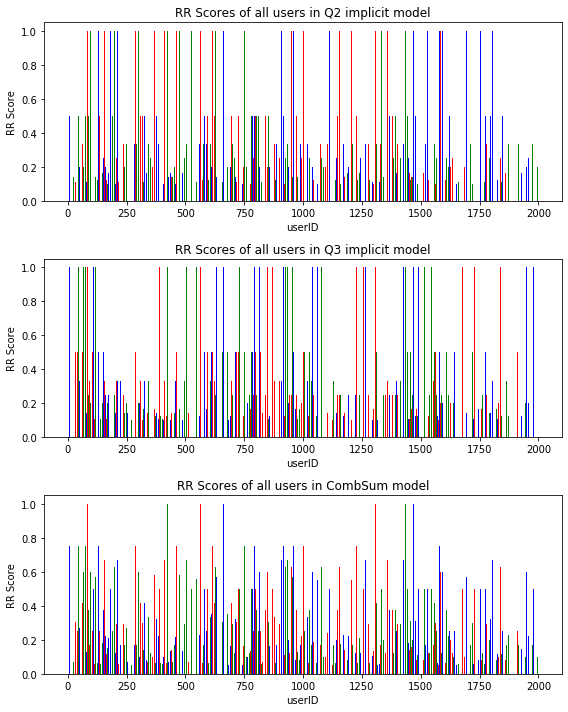

In [159]:
plt.figure(31,figsize=(8,10))
plt.subplot(311)
plt.bar(range(len(RRs_0)), RRs_0, color = 'rgb')
plt.title("RR Scores of all users in Q2 implicit model")
plt.xlabel('userID')
plt.ylabel('RR Score')
plt.tight_layout()
plt.subplot(312)
plt.bar(range(len(RRs)), RRs, color = 'rgb')
plt.title("RR Scores of all users in Q3 implicit model")
plt.xlabel('userID')
plt.ylabel('RR Score')
plt.tight_layout()
plt.subplot(313)
plt.bar(range(len(combined_RRs)), combined_RRs/2, color = 'rgb')
plt.title("RR Scores of all users in CombSum model")
plt.xlabel('userID')
plt.ylabel('RR Score')
plt.tight_layout()

#Q5

In [0]:
# select all positive rating books
all_positives = ratings_df[ratings_df["rating"] >= 4].sort_values(by=['user_id']).iloc[:,1:3]
all_pairs = pd.merge(all_positives, all_positives, on=["user_id"])
# drop duplicated rows which have same book pairs but with opposite order
sequences = all_pairs[all_pairs["book_id_x"] < all_pairs["book_id_y"]]

paircounts = sequences[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x","book_id_y"]).count()

book_pairs = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)

book_counts = ratings_df[ratings_df["rating"] >= 4].groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

allData = book_pairs.merge(book_counts, left_on="book_id_x", right_on="book_id").merge(book_counts, left_on="book_id_y", right_on="book_id")
# calculate denominator
num = float(ratings_df.count()["rating"])
# calculate Lift for all positive pairs
allData["lift"] = (allData["count"] / num) / ((allData["ratingCount_x"] / num) * (allData["ratingCount_y"] / num))
# calculate log
allData['log_lift'] = np.log(allData['lift'])
# select useful columns and sort by Lift score
allData = allData.loc[:,~allData.columns.duplicated()].sort_values(by=['lift'], ascending=False)

allData


,book_id_x,book_id_y,count,ratingCount_x,ratingCount_y,lift,log_lift
519793,1140,1302,1,1,1,124762.000000,11.734163
494143,1302,1608,1,1,1,124762.000000,11.734163
538453,880,1227,1,1,1,124762.000000,11.734163
494142,1140,1608,1,1,1,124762.000000,11.734163
537310,1811,1925,1,1,1,124762.000000,11.734163
...,...,...,...,...,...,...,...
337195,31,959,1,350,73,4.883053,1.585771
2986,154,291,1,176,147,4.822279,1.573247
48298,61,248,1,176,150,4.725833,1.553044
5269,19,112,1,220,135,4.200741,1.435261


In [0]:
# pd.options.display.max_rows = 50
plot_data=[]
# remove the books rated by users from allData table
def drop_rated_books(uid):
  book_ids = books_score
  user_rated = to_read_df[to_read_df['user_id'] == uid]['book_id']
  user_rated = user_rated.to_frame().reset_index(drop = True)
  judge = book_ids.isin(user_rated['book_id'].tolist()) == False # filter the rated ones
  temp = book_ids['book_id']
  user_recommand = book_ids[judge] 
  user_recommand['new_book_id'] = temp
  user_recommand = user_recommand.sort_values(by='new_book_id',ascending = False).iloc[:,[2,1]].fillna(0)

  return (user_recommand['log_lift'].array)

class pairsmodel:
  def predict(uid):
    rec_books = drop_rated_books(uid)
    return(rec_books)

for threshold in np.arange(3,8,0.25):
  # select useful columns
  books_score = allData.iloc[:,[1,6]]
  #define threshold for all pairs
  books_score.log_lift[books_score.log_lift < threshold] = 0
  books_score = books_score.groupby(['book_id_y']).sum().sort_values(by='log_lift',ascending = False).reset_index()
  books_score = books_score.rename(columns={'book_id_y':'book_id'})
  books_score = pd.merge(books_score, books_df['book_id'], on='book_id', how='right')

  score = mrr_score(pairsmodel, validation, train=rating_dataset).mean()
  plot_data.append(score)

  print("MRR Score for this Pairs model:",score,"with threshold:",threshold) # Takes about 2mins

threshold = 6.75

books_score = allData.iloc[:,[1,6]]
books_score.log_lift[books_score.log_lift < threshold] = 0
books_score = books_score.groupby(['book_id_y']).sum().sort_values(by='log_lift',ascending = False).reset_index()
books_score = books_score.rename(columns={'book_id_y':'book_id'})
books_score = pd.merge(books_score, books_df['book_id'], on='book_id', how='right')
score = mrr_score(pairsmodel, test_dataset, train=rating_dataset).mean()
print("MRR Score for this Pairs model:",score,"with best threshold:",threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


MRR Score for this Pairs model: 0.00262412952508 with threshold: 3.0
MRR Score for this Pairs model: 0.002644973280290939 with threshold: 3.25
MRR Score for this Pairs model: 0.002694998292797192 with threshold: 3.5
MRR Score for this Pairs model: 0.0026811024559898994 with threshold: 3.75
MRR Score for this Pairs model: 0.002618571190357083 with threshold: 4.0
MRR Score for this Pairs model: 0.0026193652381746426 with threshold: 4.25
MRR Score for this Pairs model: 0.0026816979918530695 with threshold: 4.5
MRR Score for this Pairs model: 0.0006765287405607566 with threshold: 4.75
MRR Score for this Pairs model: 0.0010213440053360012 with threshold: 5.0
MRR Score for this Pairs model: 0.001883878447160088 with threshold: 5.25
MRR Score for this Pairs model: 0.0030332626630775704 with threshold: 5.5
MRR Score for this Pairs model: 0.004463739806411141 with threshold: 5.75
MRR Score for this Pairs model: 0.0057832487672407635 with threshold: 6.0
MRR Score for this Pairs model: 0.00547615

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MRR Score for this Pairs model: 0.0684334230607367 with best threshold: 6.75


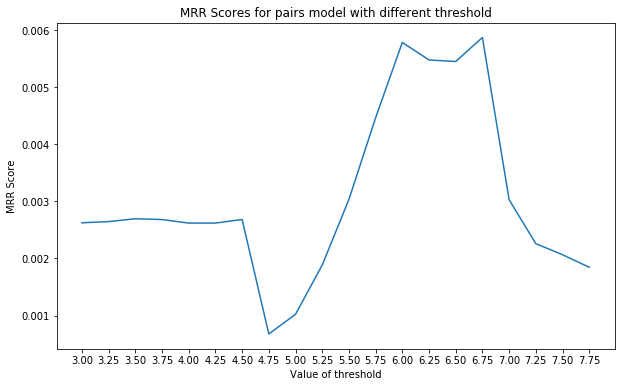

In [163]:
plt.figure(figsize=(10,6))
plt.title("MRR Scores for pairs model with different threshold")
plt.xlabel('Value of threshold')
plt.ylabel('MRR Score')
plt.xticks(np.arange(3,8,0.25))
plt.plot(np.arange(3,8,0.25),plot_data)

#Q6

In [0]:
class wedCombSummodel:
  
  def __init__(self, numitems):
    self.num = numitems

  def predict(self, uid):
    self.combsum_temp = (0.41*(imodel_0.predict(uid)/imodel_0.predict(uid).max()) + 0.58*(imodel_3.predict(uid)/imodel_3.predict(uid).max()) + 0.01*(pairsmodel.predict(uid)/pairsmodel.predict(uid).max()))
    self.combsum_prediction = self.combsum_temp
    return( self.combsum_prediction )

print("MRR Score for this wedCombSum model:",mrr_score(wedCombSummodel(num_items), test_dataset, train=rating_dataset).mean())



MRR Score for this wedCombSum model: 0.39873269968317493


#Q7

Based on all models trained, it's better to deploy a hybrid model. The hybrid model of mine contains an implicit model from Q2, implicit model from Q3 and pairs model from Q5. The performance of the combination of these three models outweighs every single model. It can reach an mrr score of 0.3987.

After tuning the embedding_dim variable within both models in Q2 and Q3, each of them can reach mrr scores of 0.365 and 0.22. Essentially, they both use a classic matrix factorization 1 approach, with latent vectors used to represent both users and items. These two models are just trained on different datasets. And their dot product gives the predicted score for a user-item pair. So introducing a recommender based on lift score can let the hybrid model not focus on *personalize* only, but some famous transactions as well. The pair-lift-based model got an mrr score of 0.068.

During the whole process of implementing various recommended models, I got more understandings about working with Spotlight and pandas, especially for constructing a model based on a pair-lift score. So many details need to be carefully considered, like the return value of *predict()*, how to exclude the books rated by the user and replace the NaN with 0. Handling these details solid my foundation about understanding how a recommender works.




In [7]:
!jt -t 

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl
